In [2]:
from collections import Counter

def find_frequent_kmer(dna_string, k):

    k_mers = [dna_string[i:i+k] for i in range(len(dna_string) - k + 1)]

    k_mer_count = Counter(k_mers)

    most_frequent = k_mer_count.most_common(1)

    return most_frequent

dna = "AGCTAGCTAGCTAGGCTA"
k = 3
most_frequent_kmer = find_frequent_kmer(dna, k)
print("Most frequent k-mer:", most_frequent_kmer)


Most frequent k-mer: [('GCT', 4)]


In [6]:
from collections import defaultdict, deque

def build_overlap_graph(kmers):
    graph = defaultdict(list)

    for kmer in kmers:
        prefix = kmer[:-1]
        suffix = kmer[1:]


        for other in kmers:
            if kmer != other and kmer[1:] == other[:-1]:
                graph[kmer].append(other)

    return graph

# Function to find a Hamiltonian path using depth-first search (DFS)
def find_hamiltonian_path(graph, start_node, visited, path):
    visited.add(start_node)
    path.append(start_node)

    if len(visited) == len(graph):
        return True

    for neighbor in graph[start_node]:
        if neighbor not in visited:
            if find_hamiltonian_path(graph, neighbor, visited, path):
                return True

    path.pop()
    visited.remove(start_node)
    return False

# Function to reconstruct the string from the Hamiltonian path
def reconstruct_from_path(path):
    # Start with the first k-mer
    reconstructed_string = path[0]

    # Append only the last character of each subsequent k-mer
    for kmer in path[1:]:
        reconstructed_string += kmer[-1]

    return reconstructed_string
kmers = ["ATT", "TTA", "TAC", "ACC", "CCA", "CAC"]

graph = build_overlap_graph(kmers)

# Find the Hamiltonian path
start_node = kmers[0]  # Start from the first k-mer
path = []
visited = set()

if find_hamiltonian_path(graph, start_node, visited, path):
    print("Hamiltonian path found:", path)

    # Reconstruct the original sequence from the path
    reconstructed_string = reconstruct_from_path(path)
    print("Reconstructed string:", reconstructed_string)
else:
    print("No Hamiltonian path found.")


Hamiltonian path found: ['ATT', 'TTA', 'TAC', 'ACC', 'CCA', 'CAC']
Reconstructed string: ATTACCAC


In [7]:
from collections import defaultdict

# Function to construct the de Bruijn graph from k-mers
def de_bruijn_graph(kmers):
    graph = defaultdict(list)

    for kmer in kmers:
        prefix = kmer[:-1]  # Prefix of length k-1
        suffix = kmer[1:]   # Suffix of length k-1
        graph[prefix].append(suffix)

    return graph

# Function to print the de Bruijn graph
def print_de_bruijn_graph(graph):
    for prefix, suffixes in graph.items():
        for suffix in suffixes:
            print(f"{prefix} -> {suffix}")

# Example usage
kmers = ["ATT", "TTA", "TAC", "ACC", "CCA", "CAC"]

# Build the de Bruijn graph
graph = de_bruijn_graph(kmers)

# Print the graph
print("De Bruijn Graph:")
print_de_bruijn_graph(graph)


De Bruijn Graph:
AT -> TT
TT -> TA
TA -> AC
AC -> CC
CC -> CA
CA -> AC


In [8]:
# Dictionary of amino acid masses
amino_acid_masses = {
    'G': 57, 'A': 71, 'S': 87, 'P': 97, 'V': 99,
    'T': 101, 'C': 103, 'I': 113, 'L': 113, 'N': 114,
    'D': 115, 'K': 128, 'Q': 128, 'E': 129, 'M': 131,
    'H': 137, 'F': 147, 'R': 156, 'Y': 163, 'W': 186
}

def linear_spectrum(peptide):
    """Calculate the linear spectrum (prefix masses) of a peptide."""
    prefix_mass = [0]  # starting mass is 0
    for i in range(len(peptide)):
        prefix_mass.append(prefix_mass[i] + amino_acid_masses[peptide[i]])

    spectrum = [0]
    for i in range(len(prefix_mass)):
        for j in range(i+1, len(prefix_mass)):
            spectrum.append(prefix_mass[j] - prefix_mass[i])

    return sorted(spectrum)

def cyclic_spectrum(peptide):
    """Calculate the cyclic spectrum of a cyclic peptide."""
    n = len(peptide)
    prefix_mass = [0] * (n + 1)
    for i in range(n):
        prefix_mass[i+1] = prefix_mass[i] + amino_acid_masses[peptide[i]]

    peptide_mass = prefix_mass[n]
    spectrum = [0]

    # Calculate subpeptide masses
    for i in range(n):
        for j in range(i + 1, n + 1):
            spectrum.append(prefix_mass[j] - prefix_mass[i])
            if i > 0 and j < n:
                spectrum.append(peptide_mass - (prefix_mass[j] - prefix_mass[i]))

    return sorted(spectrum)

def is_consistent(peptide, spectrum):
    """Check if the linear spectrum of the peptide is consistent with the given spectrum."""
    peptide_spectrum = linear_spectrum(peptide)
    peptide_spectrum_counts = {x: peptide_spectrum.count(x) for x in peptide_spectrum}
    spectrum_counts = {x: spectrum.count(x) for x in spectrum}

    for mass in peptide_spectrum_counts:
        if peptide_spectrum_counts[mass] > spectrum_counts.get(mass, 0):
            return False
    return True

def branch_and_bound_cyclopeptide_sequencing(spectrum):
    """Branch and Bound method for cyclopeptide sequencing."""
    candidate_peptides = [[]]  # Start with an empty peptide
    final_peptides = []

    parent_mass = max(spectrum)

    while candidate_peptides:
        # Expand peptides by adding one more amino acid to each candidate
        candidate_peptides = [peptide + [aa] for peptide in candidate_peptides for aa in amino_acid_masses]

        # Copy list to avoid modification while iterating
        for peptide in candidate_peptides[:]:
            peptide_mass = sum(amino_acid_masses[aa] for aa in peptide)

            if peptide_mass == parent_mass:
                # If the mass matches, check the cyclic spectrum
                if cyclic_spectrum(peptide) == spectrum:
                    final_peptides.append(peptide)
                candidate_peptides.remove(peptide)
            elif peptide_mass > parent_mass or not is_consistent(peptide, spectrum):
                # Prune the peptide if its mass exceeds or it's inconsistent with the spectrum
                candidate_peptides.remove(peptide)

    return final_peptides

def convert_to_string(peptide):
    """Convert the peptide list back to a string of amino acids."""
    return ''.join(peptide)

# Example usage
spectrum = [0, 113, 128, 186, 241, 299, 314, 427]
result = branch_and_bound_cyclopeptide_sequencing(spectrum)

# Print the found cyclic peptides
print("Cyclic peptides found:")
for peptide in result:
    print(convert_to_string(peptide))


Cyclic peptides found:
IKW
IQW
IWK
IWQ
LKW
LQW
LWK
LWQ
KIW
KLW
KWI
KWL
QIW
QLW
QWI
QWL
WIK
WIQ
WLK
WLQ
WKI
WKL
WQI
WQL


In [9]:
%pip install biopython 

In [10]:
from Bio.Blast import NCBIWWW
from Bio.Blast import NCBIXML

def blast_sequence(seq):
    result_handle = NCBIWWW.qblast("blastn", "nt", seq)
    blast_record = NCBIXML.read(result_handle)

    for alignment in blast_record.alignments:
        for hsp in alignment.hsps:
            print("*Alignment*")
            print("Sequence:", alignment.title)
            print("Length:", alignment.length)
            print("Score:", hsp.score)
            print("E-value:", hsp.expect)

query_seq = "ATGCGTACGTAGCTAGCTGACTGATCGTAGCTAGCTGACGTAGCTAGCATCGTACG"
blast_sequence(query_seq)


KeyboardInterrupt: 

In [11]:
def variant_calling(reference, sample):
    variants = []
    ref_len = len(reference)
    sample_len = len(sample)
    i = 0
    j = 0

    while i < ref_len and j < sample_len:
        if reference[i] == sample[j]:
            # Bases match, move to the next position
            i += 1
            j += 1
        else:
            # A variant has been detected
            if reference[i] != sample[j]:
                # SNP (Single Nucleotide Polymorphism)
                variants.append({
                    "type": "SNP",
                    "position": i + 1,
                    "ref_base": reference[i],
                    "sample_base": sample[j]
                })
                i += 1
                j += 1
            elif i < ref_len and j < sample_len and reference[i] != sample[j]:
                # Insertions/Deletions (indels)
                if i + 1 < ref_len and reference[i + 1] == sample[j]:
                    # Deletion in the sample
                    variants.append({
                        "type": "Deletion",
                        "position": i + 1,
                        "deleted_base": reference[i]
                    })
                    i += 1
                elif j + 1 < sample_len and reference[i] == sample[j + 1]:
                    # Insertion in the sample
                    variants.append({
                        "type": "Insertion",
                        "position": i + 1,
                        "inserted_base": sample[j]
                    })
                    j += 1

    # Check for remaining insertions or deletions
    if i < ref_len:
        for k in range(i, ref_len):
            variants.append({
                "type": "Deletion",
                "position": k + 1,
                "deleted_base": reference[k]
            })

    if j < sample_len:
        for k in range(j, sample_len):
            variants.append({
                "type": "Insertion",
                "position": ref_len + k + 1,
                "inserted_base": sample[k]
            })

    return variants


# Example usage:
reference_genome = "ACGTACGTACGT"
sample_genome = "ACGTTGGTACG"

# Call variants
variants = variant_calling(reference_genome, sample_genome)

# Print identified variants
print("Identified variants:")
for variant in variants:
    if variant["type"] == "SNP":
        print(f"SNP at position {variant['position']}: {variant['ref_base']} -> {variant['sample_base']}")
    elif variant["type"] == "Insertion":
        print(f"Insertion at position {variant['position']}: {variant['inserted_base']} inserted")
    elif variant["type"] == "Deletion":
        print(f"Deletion at position {variant['position']}: {variant['deleted_base']} deleted")


Identified variants:
SNP at position 5: A -> T
SNP at position 6: C -> G
Deletion at position 12: T deleted


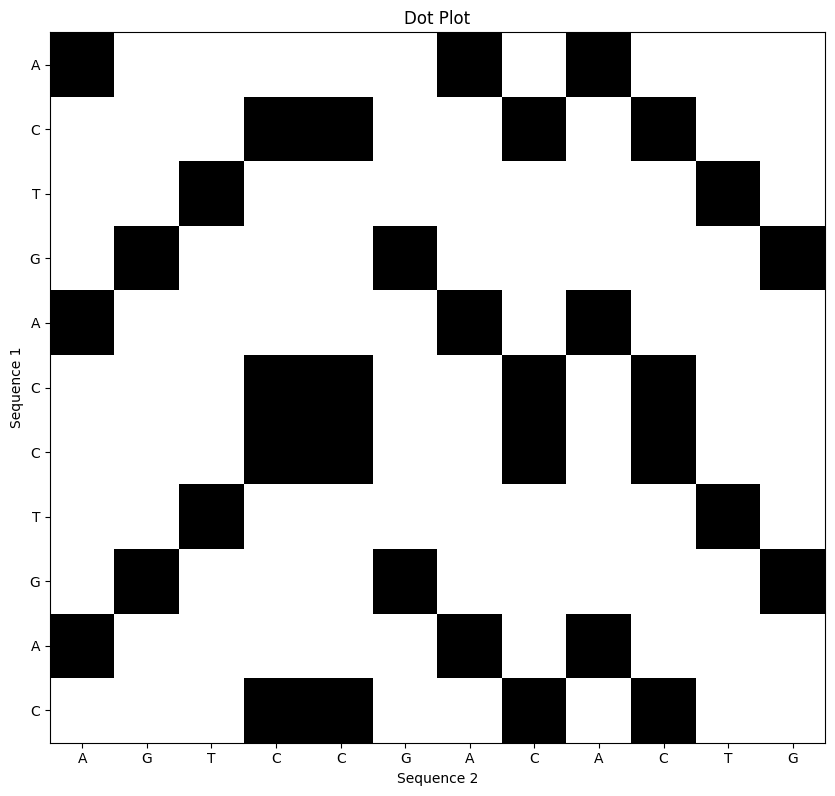

Alignment Score:
Score = -3.0


In [12]:
import numpy as np
import matplotlib.pyplot as plt

def generate_dot_plot(seq1, seq2):
    """Generates a dot plot for two sequences."""
    n = len(seq1)
    m = len(seq2)
    dot_matrix = np.zeros((n, m))

    # Fill the dot matrix
    for i in range(n):
        for j in range(m):
            if seq1[i] == seq2[j]:
                dot_matrix[i][j] = 1  # Mark a dot where sequences match

    return dot_matrix

def plot_dot_plot(dot_matrix, seq1, seq2):
    """Plots the dot plot using Matplotlib."""
    plt.figure(figsize=(10, 10))
    plt.imshow(dot_matrix, cmap='Greys', interpolation='nearest')
    plt.xticks(ticks=np.arange(len(seq2)), labels=list(seq2))
    plt.yticks(ticks=np.arange(len(seq1)), labels=list(seq1))
    plt.xlabel('Sequence 2')
    plt.ylabel('Sequence 1')
    plt.title('Dot Plot')
    plt.show()

def scoring_matrix(seq1, seq2, match=1, mismatch=-1, gap=-2):
    """Calculates the score of an alignment between two sequences."""
    n = len(seq1)
    m = len(seq2)
    score_matrix = np.zeros((n+1, m+1))

    # Initialize the score matrix with gap penalties
    for i in range(1, n+1):
        score_matrix[i][0] = i * gap
    for j in range(1, m+1):
        score_matrix[0][j] = j * gap

    # Fill the score matrix
    for i in range(1, n+1):
        for j in range(1, m+1):
            if seq1[i-1] == seq2[j-1]:
                score = match  # Match score
            else:
                score = mismatch  # Mismatch penalty

            score_matrix[i][j] = max(
                score_matrix[i-1][j-1] + score,  # Diagonal (match/mismatch)
                score_matrix[i-1][j] + gap,      # Gap in seq2 (insertion)
                score_matrix[i][j-1] + gap       # Gap in seq1 (deletion)
            )

    return score_matrix

def print_alignment_score(score_matrix):
    """Prints the final alignment score."""
    print("Alignment Score:")
    print(f"Score = {score_matrix[-1][-1]}")

# Bigger example usage
seq1 = "ACTGACCTGAC"
seq2 = "AGTCCGACACTG"

# Generate the dot plot
dot_matrix = generate_dot_plot(seq1, seq2)

# Plot the dot plot
plot_dot_plot(dot_matrix, seq1, seq2)

# Generate the scoring matrix
score_matrix = scoring_matrix(seq1, seq2)

# Print the score
print_alignment_score(score_matrix)



In [13]:
def match_mismatch_score(seq1, seq2, match_score=1, mismatch_penalty=-1):
    """
    Function to compute the match/mismatch score between two sequences.

    Parameters:
    - seq1: First sequence (string)
    - seq2: Second sequence (string)
    - match_score: Score for a match (default = 1)
    - mismatch_penalty: Penalty for a mismatch (default = -1)

    Returns:
    - total_score: Total score based on match/mismatch
    """
    if len(seq1) != len(seq2):
        raise ValueError("Sequences must be of equal length")

    total_score = 0

    # Compare each base pair in the aligned sequences
    for base1, base2 in zip(seq1, seq2):
        if base1 == base2:
            total_score += match_score  # Match score
        else:
            total_score += mismatch_penalty  # Mismatch penalty

    return total_score

# Example usage
seq1 = "AGCTTAGC"
seq2 = "AGCTCAGC"

# Calculate the match/mismatch score with default scoring scheme
score = match_mismatch_score(seq1, seq2)

print(f"Match/Mismatch score between '{seq1}' and '{seq2}': {score}")


Match/Mismatch score between 'AGCTTAGC' and 'AGCTCAGC': 6


In [14]:
import numpy as np

def needleman_wunsch(seq1, seq2, match_reward=2, mismatch_penalty=-1, gap_penalty=-1):
    # Create a matrix to store the scores
    n = len(seq1)
    m = len(seq2)
    score_matrix = np.zeros((n + 1, m + 1))

    # Initialize the scoring matrix with gap penalties
    for i in range(1, n + 1):
        score_matrix[i][0] = i * gap_penalty
    for j in range(1, m + 1):
        score_matrix[0][j] = j * gap_penalty

    # Fill the scoring matrix
    for i in range(1, n + 1):
        for j in range(1, m + 1):
            match = score_matrix[i - 1][j - 1] + (match_reward if seq1[i - 1] == seq2[j - 1] else mismatch_penalty)
            delete = score_matrix[i - 1][j] + gap_penalty
            insert = score_matrix[i][j - 1] + gap_penalty
            score_matrix[i][j] = max(match, delete, insert)

    # Traceback to create the alignment
    align1, align2 = '', ''
    i, j = n, m

    while i > 0 and j > 0:
        score_current = score_matrix[i][j]
        score_diagonal = score_matrix[i - 1][j - 1]
        score_up = score_matrix[i - 1][j]
        score_left = score_matrix[i][j - 1]

        if score_current == score_diagonal + (match_reward if seq1[i - 1] == seq2[j - 1] else mismatch_penalty):
            align1 += seq1[i - 1]
            align2 += seq2[j - 1]
            i -= 1
            j -= 1
        elif score_current == score_up + gap_penalty:
            align1 += seq1[i - 1]
            align2 += '-'
            i -= 1
        elif score_current == score_left + gap_penalty:
            align1 += '-'
            align2 += seq2[j - 1]
            j -= 1

    # Add remaining characters/gaps if needed
    while i > 0:
        align1 += seq1[i - 1]
        align2 += '-'
        i -= 1
    while j > 0:
        align1 += '-'
        align2 += seq2[j - 1]
        j -= 1

    # Reverse the alignments since we traced back
    align1 = align1[::-1]
    align2 = align2[::-1]

    # Get final alignment score
    final_score = score_matrix[n][m]

    return score_matrix, align1, align2, final_score

# Test example
seq1 = "GATTACA"
seq2 = "GCATGCU"

# Run Needleman-Wunsch algorithm
score_matrix, alignment1, alignment2, final_score = needleman_wunsch(seq1, seq2)

print("Score Matrix:")
print(score_matrix)

print("\nAlignment:")
print(alignment1)
print(alignment2)

print("\nFinal Alignment Score:", final_score)


Score Matrix:
[[ 0. -1. -2. -3. -4. -5. -6. -7.]
 [-1.  2.  1.  0. -1. -2. -3. -4.]
 [-2.  1.  1.  3.  2.  1.  0. -1.]
 [-3.  0.  0.  2.  5.  4.  3.  2.]
 [-4. -1. -1.  1.  4.  4.  3.  2.]
 [-5. -2. -2.  1.  3.  3.  3.  2.]
 [-6. -3.  0.  0.  2.  2.  5.  4.]
 [-7. -4. -1.  2.  1.  1.  4.  4.]]

Alignment:
G-ATTACA
GCA-TGCU

Final Alignment Score: 4.0
